In [18]:
# Manual load + fresh reload for ml4fmri
import sys, importlib
from pathlib import Path

PKG = "ml4fmri"
# adjust as needed; this assumes your repo root is the CWD and sources are in ../src
SRC = Path().joinpath("../src").resolve()

def _ensure_src_on_path():
    p = str(SRC)
    if p not in sys.path:
        sys.path.insert(0, p)

def fresh_import_ml4fmri(verbose=True):
    """
    Remove any cached ml4fmri modules and import from SRC.
    Returns the ml4fmri module and (if available) meanMLP class.
    """
    _ensure_src_on_path()

    # purge previous imports so code changes take effect
    to_delete = [k for k in list(sys.modules) if k == PKG or k.startswith(PKG + ".")]
    for k in to_delete:
        del sys.modules[k]

    importlib.invalidate_caches()

    ml4fmri = __import__(PKG)
    meanMLP = None
    try:
        from ml4fmri.models import meanMLP  # keep your casing
    except Exception as e:
        if verbose:
            print("Note: could not import meanMLP yet:", e)

    if verbose:
        try:
            import inspect
            print("ml4fmri imported from:", Path(inspect.getfile(ml4fmri)).parent)
        except Exception:
            pass
    return ml4fmri, meanMLP

# --- first import (or manual reload later) ---
ml4fmri, meanMLP = fresh_import_ml4fmri(verbose=False)
print("ml4fmri ready; meanMLP =", meanMLP)

ml4fmri ready; meanMLP = <class 'ml4fmri.models.meanMLP.meanMLP'>


In [2]:
from abide import load_data as load_abide
from cobre import load_data as load_cobre

data, labels = load_abide()
data.shape, labels.shape

((569, 140, 53), (569,))

In [3]:
from ml4fmri.models import meanMLP

dataloader = meanMLP.prepare_dataloader(
    data, labels
)
dataloader

In [4]:
model = meanMLP(53, 2)
model

meanMLP(
  (mlp): Sequential(
    (0): Linear(in_features=53, out_features=160, bias=True)
    (1): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Dropout(p=0.49, inplace=False)
    (4): Linear(in_features=160, out_features=2, bias=True)
  )
)

In [5]:
class_name = model.__class__.__name__
print(class_name)

meanMLP


In [6]:
from sklearn.model_selection import train_test_split

# Split data into train (60%) and temp (40%)
data_train, data_temp, labels_train, labels_temp = train_test_split(data, labels, test_size=0.4, random_state=42)

# Split temp into validation (50% of temp, i.e., 20% of total) and test (50% of temp, i.e., 20% of total)
data_val, data_test, labels_val, labels_test = train_test_split(data_temp, labels_temp, test_size=0.5, random_state=42)

# Print the shapes of the resulting splits
print("Train set:", data_train.shape, labels_train.shape)
print("Validation set:", data_val.shape, labels_val.shape)
print("Test set:", data_test.shape, labels_test.shape)

Train set: (341, 140, 53) (341,)
Validation set: (114, 140, 53) (114,)
Test set: (114, 140, 53) (114,)


In [7]:
train_dataloader = meanMLP.prepare_dataloader(
    data_train, labels_train
)
val_dataloader = meanMLP.prepare_dataloader(
    data_val, labels_val, shuffle=False
)
test_dataloader = meanMLP.prepare_dataloader(
    data_test, labels_test, shuffle=False
)

model = meanMLP(53, 2)

train_logs, test_logs = model.train_model(
    train_dataloader,
    val_dataloader,
    test_dataloader,
    epochs=10,
    patience=3,
    lr=0.001
)

In [27]:
test_logs.to_csv("test_logs.csv", index=False)
train_logs.to_csv("train_logs.csv", index=False)

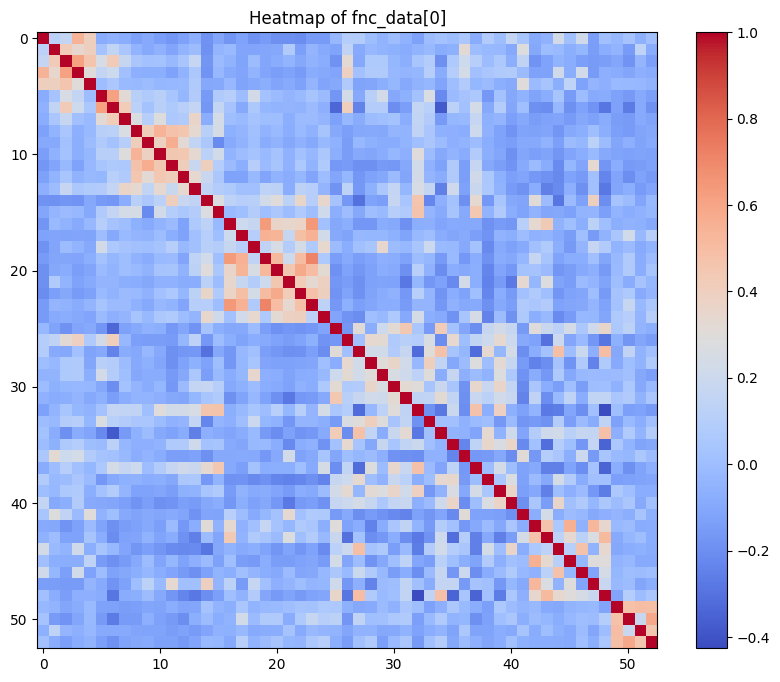

In [8]:
data.shape
from ml4fmri.models.helper_functions import corrcoef_batch

fnc_data = corrcoef_batch(data)
fnc_data.shape
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(fnc_data.mean(axis=0), cmap="coolwarm", aspect="auto")
plt.colorbar()
plt.title("Heatmap of fnc_data[0]")
plt.show()

In [ ]:
from polyssifier import poly
# Load data
# data = np.load("/path/to/data.npy")
# label = np.load("/path/to/labels.npy")
# Run analysis
from ml4fmri.models.helper_functions import corrcoef_batch
fnc_data = corrcoef_batch(data)
fnc_data = fnc_data.reshape(fnc_data.shape[0], -1)  # Flatten the 3D data to 2D
report = poly(fnc_data,labels, n_folds=8)
# Plot results
report.plot_scores()
report.plot_features(ntop=10)

2025-08-14 00:28:59,487 - polyssifier - INFO - Detected 2 classes in label
2025-08-14 00:28:59,488 - polyssifier - INFO - Building classifiers ...
2025-08-14 00:28:59,490 - polyssifier - INFO - Initialization, done.
2025-08-14 00:28:59,858 - polyssifier - INFO - Training Multilayer Perceptron 0
2025-08-14 00:29:01,503 - polyssifier - INFO - Multilayer Perceptron      0: Train 1.00/Test 0.63, 1.64 sec
2025-08-14 00:29:01,617 - polyssifier - INFO - Training Multilayer Perceptron 1
2025-08-14 00:29:03,176 - polyssifier - INFO - Multilayer Perceptron      1: Train 1.00/Test 0.72, 1.56 sec
2025-08-14 00:29:03,291 - polyssifier - INFO - Training Multilayer Perceptron 2
2025-08-14 00:29:05,108 - polyssifier - INFO - Multilayer Perceptron      2: Train 1.00/Test 0.81, 1.82 sec
2025-08-14 00:29:05,234 - polyssifier - INFO - Training Multilayer Perceptron 3
/Users/ppopov1/miniconda3/envs/meanmlp-dev/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:788: UserWarning: T

In [9]:
import ml4fmri.models as mdl

found = {}
for name in dir(mdl):
    obj = getattr(mdl, name, None)
    nested_obj = getattr(obj, name, None)
    if hasattr(obj, "prepare_dataloader") and hasattr(obj, "train_model"):
        found[name] = obj
    if (nested_obj and hasattr(nested_obj, "prepare_dataloader") and hasattr(nested_obj, "train_model")):
        found[name] = nested_obj
found

{'meanLSTM': ml4fmri.models.meanLSTM.meanLSTM,
 'meanMLP': ml4fmri.models.meanMLP.meanMLP}

In [64]:
ml4fmri, meanMLP = fresh_import_ml4fmri(verbose=False)

In [65]:
from ml4fmri import cvbench
cvbench

<function ml4fmri.report.cvbench(data, labels, models: str | list[str] = 'lite', n_folds: int = 10, val_ratio: float = 0.2, random_state: int = 42, epochs: int = 200, lr: float = None, device: str = None, patience: int = 30)>

In [68]:
report_basic = cvbench(data, labels, models='lite', n_folds=5)

cvbench INFO: Training model: meanMLP
cvbench.meanMLP INFO: Fold 1/5: Test AUC 0.744
cvbench.meanMLP INFO: Fold 2/5: Test AUC 0.711
cvbench.meanMLP INFO: Fold 3/5: Test AUC 0.746
cvbench.meanMLP INFO: Fold 4/5: Test AUC 0.733
cvbench.meanMLP INFO: Fold 5/5: Test AUC 0.814


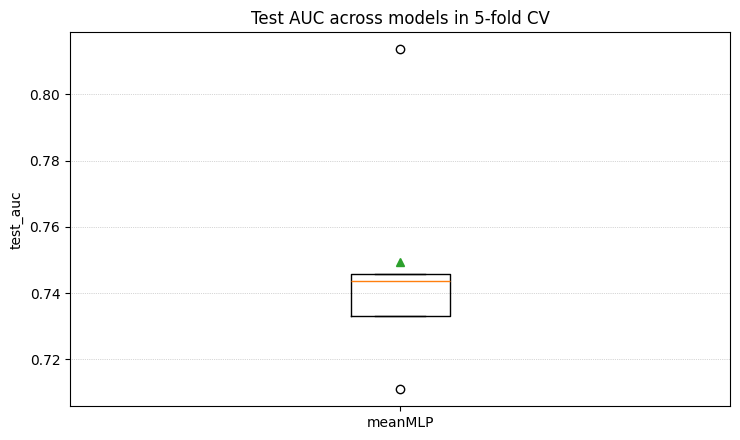

In [73]:
report_basic.plot_scores()

(<Figure size 750x300 with 1 Axes>, <Figure size 750x300 with 1 Axes>)

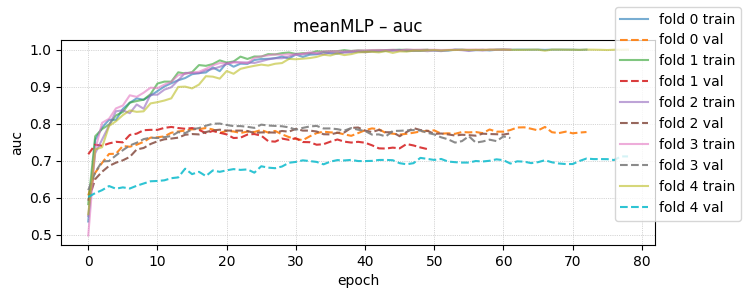

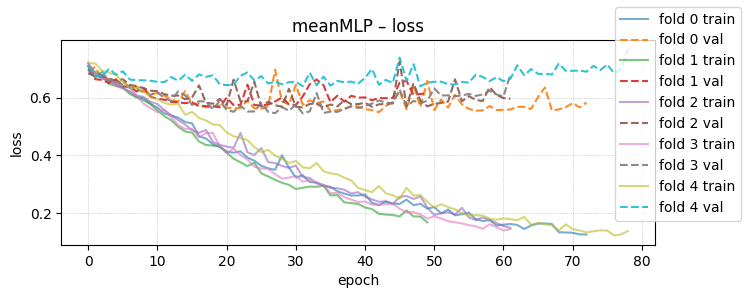

In [74]:
report_basic.plot_training_curves()

In [ ]:
report = cvbench(data, labels, models='all', n_folds=5)
report.plot_scores()


cvbench INFO: Training model: meanLSTM
